In [42]:
import os
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset
import mne
import pandas as pd



## Load Test Data

In [2]:
eye_movement_features = './data/Eye_movement_features'
eeg_features = './data/EEG_DE_features'

In [43]:
# label_dict = {0:'Disgust', 1:'Fear', 2:'Sad', 3:'Neutral', 4:'Happy'}
def load_eeg_data(eeg_dir, file_name):
    eeg_data_pickle = np.load( os.path.join(eeg_dir, file_name))
    data = pickle.loads(eeg_data_pickle['data'])
    label = pickle.loads(eeg_data_pickle['label'])
    label_dict = {0:'Disgust', 1:'Fear', 2:'Sad', 3:'Neutral', 4:'Happy'}
    # print(data)
    for i in range(45):
        print(f"\tSession {i//15+1} - Clip #{i%15+1} ----> {label_dict[label[i][0]]}")

def load_eye_data(eye_dir, file_name):
    eye_data_pickle = np.load( os.path.join(eye_dir, file_name))
    data = pickle.loads(eye_data_pickle['data'])
    label = pickle.loads(eye_data_pickle['label'])
    label_dict = {0:'Disgust', 1:'Fear', 2:'Sad', 3:'Neutral', 4:'Happy'}
    for i in range(45):
        print(f"\tSession {i//15+1} - Clip #{i%15+1} ----> {label_dict[label[i][0]]}")


In [25]:
eeg_dir = eeg_features
eye_dir = eye_movement_features
file_list = os.listdir(eeg_dir)
file_list.sort()

res_dir = './res/cv3/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
cv = 1

for f_id in file_list:
    # print(f_id)
    print(f"******************** {f_id} ********************")
    print("EEG DATA")
    load_eeg_data(eeg_dir, f_id)
    print("EYE TRACKING DATA")
    load_eye_data(eye_dir, f_id)

******************** 1_123.npz ********************
EEG DATA
	Session 1 - Clip #1 ----> Happy
	Session 1 - Clip #2 ----> Fear
	Session 1 - Clip #3 ----> Neutral
	Session 1 - Clip #4 ----> Sad
	Session 1 - Clip #5 ----> Disgust
	Session 1 - Clip #6 ----> Happy
	Session 1 - Clip #7 ----> Fear
	Session 1 - Clip #8 ----> Neutral
	Session 1 - Clip #9 ----> Sad
	Session 1 - Clip #10 ----> Disgust
	Session 1 - Clip #11 ----> Happy
	Session 1 - Clip #12 ----> Fear
	Session 1 - Clip #13 ----> Neutral
	Session 1 - Clip #14 ----> Sad
	Session 1 - Clip #15 ----> Disgust
	Session 2 - Clip #1 ----> Sad
	Session 2 - Clip #2 ----> Fear
	Session 2 - Clip #3 ----> Neutral
	Session 2 - Clip #4 ----> Disgust
	Session 2 - Clip #5 ----> Happy
	Session 2 - Clip #6 ----> Happy
	Session 2 - Clip #7 ----> Disgust
	Session 2 - Clip #8 ----> Neutral
	Session 2 - Clip #9 ----> Sad
	Session 2 - Clip #10 ----> Fear
	Session 2 - Clip #11 ----> Neutral
	Session 2 - Clip #12 ----> Happy
	Session 2 - Clip #13 ----> Fear

## Load Raw Data

In [5]:
eeg_raw = './data/EEG_raw'
eye_raw = './data/Eye_raw'

eeg_dir = eeg_raw
eye_dir = eye_raw
file_list = os.listdir(eeg_dir)
file_list.sort()

res_dir = './res/cv3/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [6]:
# EEG RAW DATA
for f_id in file_list:
    print(f_id)
    eeg_raw = mne.io.read_raw_cnt(f'./data/EEG_raw/{f_id}')
    print(eeg_raw)
    print('\n')
    print(eeg_raw.info)

1_1_20180804.cnt
<RawCNT | 1_1_20180804.cnt, 66 x 3378360 (3378.4 s), ~81 kB, data not loaded>


<Info | 9 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 66 EEG
 custom_ref_applied: False
 dig: 69 items (3 Cardinal, 66 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2018-04-08 17:35:05 UTC
 nchan: 66
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>


In [7]:
ch_names = eeg_raw.ch_names

# drop non-used channels
useless_ch = ['M1', 'M2', 'VEO', 'HEO']
eeg_raw.drop_channels(useless_ch)
new_ch = eeg_raw.ch_names
print(new_ch)
print(len(new_ch))

['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']
62


## Visualize Data with MNE

Using matplotlib as 2D backend.


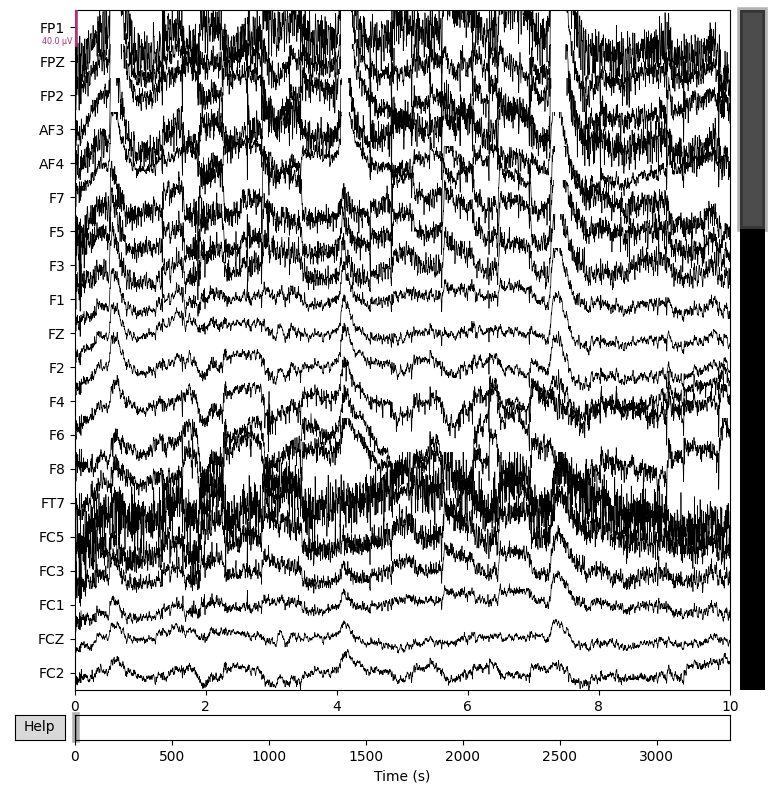

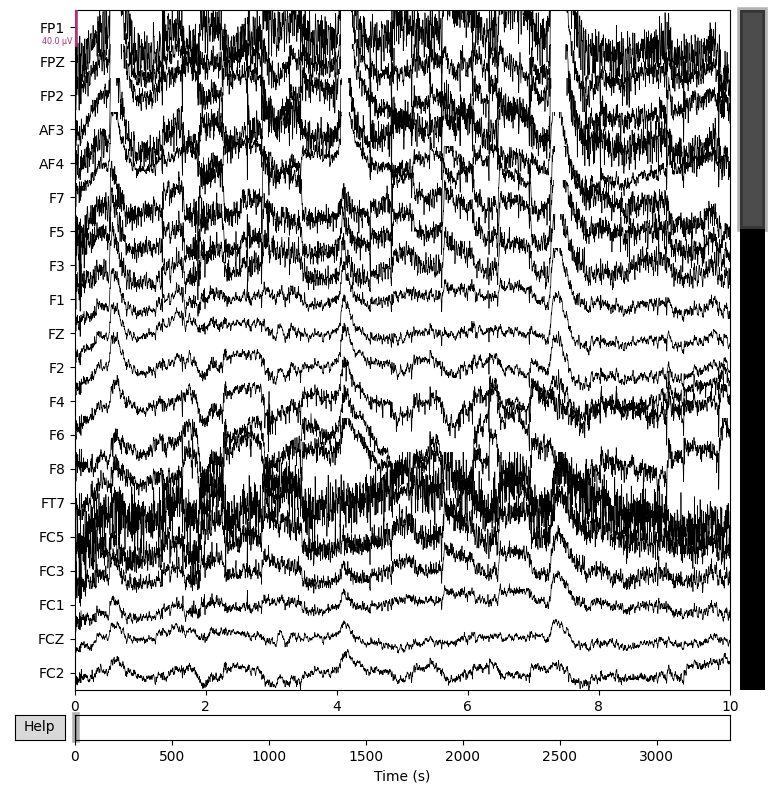

In [8]:
eeg_raw.plot()

In [9]:
data_matrix = eeg_raw.get_data()
print(data_matrix.shape)

(62, 3378360)


## Timestamp EEG

In [50]:
# Session #3
start_second = [30, 353, 478, 674, 825, 908, 1200, 1346, 1451, 1711, 2055, 2307, 2457, 2726, 2888]
end_second = [321, 418, 643, 764, 877, 1147, 1284, 1418, 1679, 1996, 2275, 2425, 2664, 2857, 3066]
sample_freq = 1000

data_trial_1 = data_matrix[:, start_second[0]*1000 : end_second[0]*1000]
data_trial_5 = data_matrix[:, start_second[4]*1000 : end_second[4]*1000]
data_trial_15 = data_matrix[:, start_second[14]*1000 : end_second[14]*1000]

print(data_trial_1)
print(data_trial_5)
print(data_trial_15)

[[-3.29911709e-05 -2.79843807e-05 -1.68383121e-05 ... -2.11596489e-06
   1.20699406e-05  2.33054161e-05]
 [-2.70903111e-05 -2.87294388e-05 -3.02195549e-05 ...  2.20537186e-05
   2.79247761e-05  3.25441360e-05]
 [-1.68085098e-05 -1.37984753e-05 -1.36196613e-05 ...  8.73208046e-06
   1.09970570e-05  1.14142895e-05]
 ...
 [-1.07288361e-05 -9.26852226e-06 -9.32812691e-06 ...  6.79492950e-06
   8.70227814e-06  9.38773155e-06]
 [ 8.94069672e-08  1.01327896e-06  1.13248825e-06 ...  7.98702240e-06
   8.31484795e-06  8.22544098e-06]
 [-8.94069672e-08  7.15255737e-07  3.87430191e-07 ...  1.06394291e-05
   1.14738941e-05  1.17123127e-05]]
[[ 5.36441803e-07  4.61935997e-06  6.58631325e-06 ...  3.93092632e-05
   3.85642052e-05  3.73721123e-05]
 [ 2.54511833e-05  1.89542770e-05  8.85128975e-06 ...  2.78949738e-05
   1.26957893e-05 -2.68220901e-06]
 [ 1.39772892e-05  1.45733356e-05  1.62124634e-05 ...  2.89380550e-05
   2.64048576e-05  2.39610672e-05]
 ...
 [ 4.55975533e-06  7.24196434e-06  1.0401010

## Process Data

In [11]:
eeg_raw = './data/EEG_raw/1_1_20180804.cnt'
eye_raw = './data/Eye_raw/Session_1/10_1_20180507.xlsx'

### DataLoader

In [107]:
class myDataset(Dataset):
    def __init__(self, eeg_raw, eye_raw):
        self.eeg_data = mne.io.read_raw_cnt(eeg_raw)
        self.eye_data = pd.read_excel(eye_raw)

    def __len__(self):
        # return len(self.eeg_data)
        return min(len(self.eeg_data), len(self.eye_data))

    def __getitem__(self, index):
        eeg_channel_name = 'FP1'  
        eeg_signal = self.eeg_data[eeg_channel_name][0][0]

        eye_signal = self.eye_data.iloc[index, 0]

        eeg_signal_tensor = torch.tensor(eeg_signal)
        eye_signal_tensor = torch.tensor(eye_signal)

        eeg_mean = torch.mean(eeg_signal_tensor)
        eeg_std = torch.std(eeg_signal_tensor)
        eye_mean = torch.mean(eye_signal_tensor)
        eye_std = torch.std(eye_signal_tensor)

        # Normalize the signal data
        eeg_signal_tensor = (eeg_signal_tensor - eeg_mean) / eeg_std
        eye_signal_tensor = (eye_signal_tensor - eye_mean) / eye_std

        return eeg_signal_tensor, eeg_mean, eeg_std, eye_signal_tensor, eye_mean, eye_std

# Create a dataset from the EEG and eye files
dataset = myDataset(eeg_raw, eye_raw)
# Create a data loader for the dataset
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

##### Samples

In [108]:
# dataset.shape = 151 samples
# tamaño de cada sample:  6 (eeg_signal_tensor, eeg_mean, eeg_std, eye_signal_tensor, eye_mean, eye_std)
print(dataset[0])

(tensor([-0.8972, -0.8723, -0.9047,  ...,  3.2437,  3.0493,  2.8220],
       dtype=torch.float64), tensor(1.4153e-08, dtype=torch.float64), tensor(5.5059e-05, dtype=torch.float64), tensor(nan, dtype=torch.float64), tensor(366., dtype=torch.float64), tensor(nan, dtype=torch.float64))


In [109]:
# iterate over data_loader
# TODO: investigar cómo lidiar con nan
next(iter(data_loader))

[tensor([[-0.8972, -0.8723, -0.9047,  ...,  3.2437,  3.0493,  2.8220]],
        dtype=torch.float64),
 tensor([1.4153e-08], dtype=torch.float64),
 tensor([5.5059e-05], dtype=torch.float64),
 tensor([nan], dtype=torch.float64),
 tensor([nan], dtype=torch.float64),
 tensor([nan], dtype=torch.float64)]

##### EEG_signal_tensor from Dataset Class

In [110]:
print(len(dataset[0][0])) #3378360 (datos de un sólo canal)

3378360


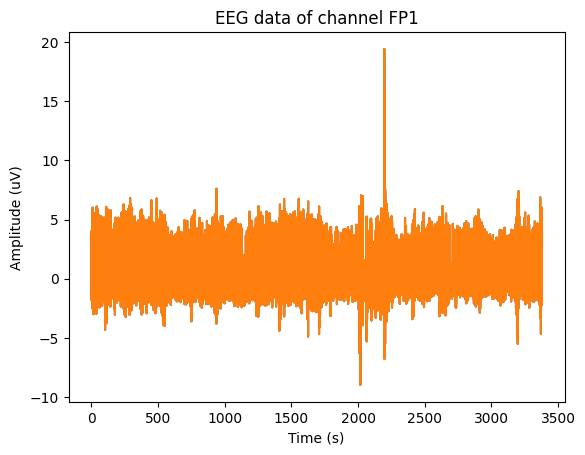

In [133]:
import matplotlib.pyplot as plt

channel = 'FP1'

# Assuming your tensor is named 'eeg_tensor' and has shape (3378360,)
eeg_channel_data = dataset[0][0]

# Create a time vector corresponding to the data
time = range(len(eeg_channel_data))
time = [t/1000 for t in time]  # Convert to seconds

# Create a line plot of the EEG channel data
plt.plot(time, eeg_channel_data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('EEG data of channel FP1')
plt.show()